# DISUNITED AIRLINES - Airline Reservation Database  

### Philip Abraham, December 15th, 2020

# 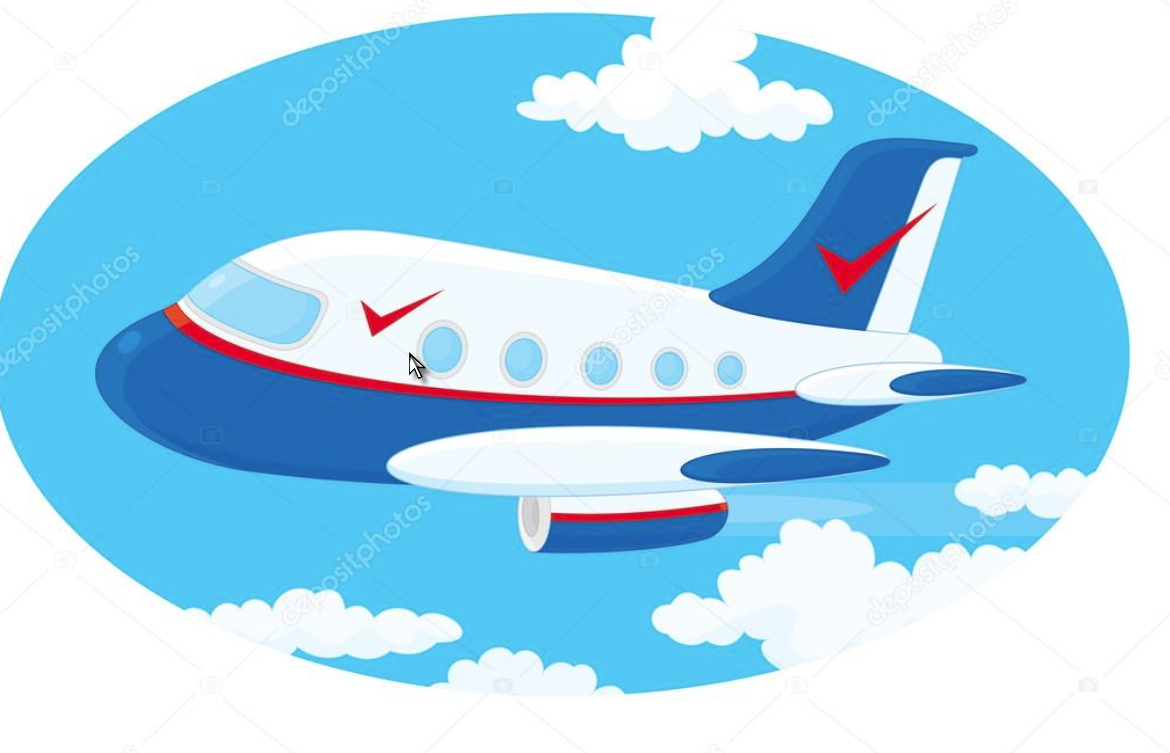

Pic Source: https://depositphotos.com/vector-images/airplane-cartoon.html?qview=30852607

**<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>**

## Introduction

An Airline Reservation Database (ARD) system is created for DisUnited Airlines to implement the process of booking a seat for a customer on DisUnited flights between two cities.   

The ARD affords the user  a choice of eight airports for flight travel origination and destination. It lists available flights times for the selected origin/destinations, for up to a month in advance.  Moreover, in the process of reserving the flight, the ARD user is given the option of picking a seat in either Economy, Business or First Class.   

The DisUnited Airlines utilizes aircrafts from Boeing, Airbus and Embraer companies to provide the required flights. The aircraft seating configurations were implemented in the ARD per each respective aircraft's seat arrangement available on the internet.  

There is also a flight check-in option available on the ARD for customers to check-in to their within 24 hours of their flight.  
The ARD has been designed implementing all the project requirements. All database normalization, entity integrity protocols and enterprise logic have been strictly followed in this ARD design.

## Project Scope and Requirements

1. Design the specified database schema.
    - Normalized tables: make clear what entity type corresponds to each table
    - Entity integrity: well-chosen primary key, 1-to-1 correspondence to the real world.
    - Dependencies using foreign keys. Model relationships that correspond to the rules.
    - Ensure that the database enforces all the rules and logic of the enterprise.
    - Define additional unique indexes if necessary 
    
2. Scripts to populate the tables
    - Define functions that define real-world transactions.
    - Use serializable transactions if necessary. 
    - Use these functions in a simulation for a large number of diverse transactions.
    - Populate all tables with enough data for meaningful queries.
    
3. Interesting queries
    - Create eight meaningful queries.
    - Five queries will be given in the assignment and you will need to come up with at least three more of equal complexity.
    - Make sure that you find queries that use joins, subqueries, and aggregation functions.
    - Each query should be implemented as a single database query with no postprocessing required.


### Entities
* Passenger
* Aircraft Type
* Seats
* Airports
* Flights
* Reservations
* Checkin

### Rules and Operations

1. **Passengers** are identified by a surrogate key (int, uuid) but ensure uniqueness through a secondary index. Date of birth, citizenship, id type, and id number. 
1. **Seat** arrangements are defined for each **Aircraft Type**, have a seat number such as 1A, 33F and class (Economy, Business, and 1st Class). 
1. **Airports** (identifed by codes) have coordinates (lattitude and longitude). `IAH`, `HOU`, `LAX`, `JFK`, `DCA`, `SAN`, `SEA`, `LAS`, `SLC`. Use at least seven.
1. **Flights** departure time, **Aircraft Type**, Origin (airport code), Destination (airport code), distance, arrival time, economy price.
1. **Reservations** are for direct **Flights** only and for one **Passenger** only = 1 seat, assigned to a seat, price is the flight price x1.5 for business, x2.0 for 1st class. Write the function `reserve_seat` that implements the purchase of a reservation. 
1. **Seats on flights** Available are seats are defined from the **Aircarft Type**.
1. **Check-in** is performed for a reservation and must be within 24 hours before the flight but not after. 

### Data
Populate at least `n^1.5` of flights per day where `n` is the number of airports, for at least 1 month.
Populate flights to be on average at least 75% full, but randomize.

### Example Queries


Write at least 8 interesting queries. 

1. Show the flight schedule between two cities between two dates.
2. All cities with direct flights from a given airport (e.g. from IAH) or from two airports (e.g. IAH and HOU) between two dates. "To what cities can I fly from New York in the next two days?"
3. Next available (has seats) flight between given cities.
4. For each passenger, report total miles traveled and money spent.
5. Report occupancy rate (%full) for all flights between two cities within a given period.
6. -- be creative --
7. -- be creative --
8. -- be creative --

## Database Creation and Records Insertion

#### Import necessary python packages

In [1]:
import numpy as np
import random
import datetime
from faker import Faker
from geopy.distance import geodesic
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#### Import necessary DB connection packages

In [3]:
import pymysql
import json

In [4]:
# Add the command below to anywhere before making pymysql connection. It adds new encoder of numpy.float64.
pymysql.converters.encoders[np.float64] = pymysql.converters.escape_float
pymysql.converters.conversions = pymysql.converters.encoders.copy()
pymysql.converters.conversions.update(pymysql.converters.decoders)

In [5]:
# establish a database connection
with open('cred.json') as f:
    creds = json.load(f)
conn = pymysql.connect(
    host=creds['host'], 
    user=creds['user'], 
    passwd=creds['password'],
    autocommit=True)

In [6]:
cursor = conn.cursor(cursor=pymysql.cursors.DictCursor)

In [ ]:
cursor.execute("""
CREATE SCHEMA abrahap_AirlineReservations
""")

In [7]:
cursor.execute("""
USE abrahap_AirlineReservations
""")

0

### Aircraft Table 

In [ ]:
cursor.execute("""
CREATE TABLE `aircraft` (
aircraft varchar(16) NOT NULL,
PRIMARY KEY (aircraft)
)
""")

In [ ]:
for craft in ('Boeing 737-800', 'Airbus A320', 'EMBRAER 175'):
    cursor.execute("INSERT INTO aircraft VALUES (%s)", (craft,))

In [18]:
cursor.execute("""
SELECT * FROM aircraft
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,aircraft
0,Airbus A320
1,Boeing 737-800
2,EMBRAER 175


In [17]:
# show all rows of a pandas dataframe
pd.set_option('display.max_rows', fetchall_df.shape[0]+1)

### Seat Table

Seat arrangements for the three respective airlines used in the database were obtained from:  
https://www.seatguru.com/browseairlines/browseairlines.php

In [ ]:
cursor.execute("""
CREATE TABLE `seat` (
aircraft varchar(16) NOT NULL,
seat char(3) NOT NULL,
class enum('Economy', 'Business', 'First Class') NOT NULL,
PRIMARY KEY (aircraft, seat),
FOREIGN KEY (aircraft) REFERENCES aircraft(aircraft) 
)
""")

In [ ]:
aircraft = "Boeing 737-800"
klass = "First Class" 
for row in range(1, 5):
    for seat in "ABEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))


In [ ]:
aircraft = "Boeing 737-800"
klass = "Business" 
for row in range(7, 16):
    for seat in "ABCDEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "Boeing 737-800"
klass = "Economy" 
for row in range(22, 38):
    for seat in "ABCDEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "Airbus A320"
klass = "First Class" 
for row in range(1, 4):
    for seat in "ABEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "Airbus A320"
klass = "Business" 
for row in range(7, 14):
    for seat in "ABCDEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "Airbus A320"
klass = "Economy" 
for row in range(22, 39):
    for seat in "ABCDEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "EMBRAER 175"
klass = "First Class" 
for row in range(1, 5):
    for seat in "ABC":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "EMBRAER 175"
klass = "Business" 
for row in range(7, 10):
    for seat in "ABCD":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [ ]:
aircraft = "EMBRAER 175"
klass = "Economy" 
for row in range(10, 25):
    for seat in "ABCDEF":
        cursor.execute("""
        INSERT INTO `seat` (`aircraft`, `class`, `seat`) 
        VALUES (%s, %s, %s)""", (aircraft, klass, str(row) + seat))

In [19]:
cursor.execute("""
SELECT * FROM seat
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df.loc[fetchall_df['aircraft']=='EMBRAER 175'].sort_values(by=['class','seat'])

,aircraft,seat,class
424,EMBRAER 175,7A,Business
425,EMBRAER 175,7B,Business
...,...,...,...
422,EMBRAER 175,4B,First Class
423,EMBRAER 175,4C,First Class


### Airport Table 

GPS coordinates of airport locations were obtaines from:  
https://www.latlong.net/category/airports-236-19.html

In [ ]:
cursor.execute("""
CREATE TABLE `airport` (
airport_code CHAR(3) NOT NULL,
airport_name VARCHAR(80) NOT NULL,
latitude FLOAT NOT NULL,
longitude FLOAT NOT NULL,
PRIMARY KEY (airport_code)
)
""")

In [ ]:
cursor.execute("""
INSERT INTO airport (airport_code,airport_name,latitude,longitude)
                   VALUES ('JFK', 'John F. Kennedy International Airport, New York,  NY', 40.641766,	-73.780968),
                           ('DFW', 'Dallas/Fort Worth International Airport, Dallas, TX', 32.897480, -97.040443),
                           ('ORD', 'O’Hare International Airport, Chicago, IL', 41.978611, -87.904724),
                           ('LAX', 'Los Angeles International Airport, Los Angeles, CA',	33.942791,	-118.410042),
                           ('BOS', 'Logan International Airport (BOS), Boston, MA',	42.366978, -71.022362),
                           ('SEA', 'Seattle-Tacoma International Airport, Seattle, WA',	47.443546, -122.301659),
                           ('IAH', 'George Bush Intercontinental Houston Airport, Houston, TX',	29.9843998,	-95.34140015),
                           ('TPA','Tampa International Airport, Tampa, FL',	27.979168,	-82.539337)
                           
                           
""")

In [20]:
cursor.execute("""
SELECT * FROM airport
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,airport_code,airport_name,latitude,longitude
0,BOS,"Logan International Airport (BOS), Boston, MA",42.3670,-71.0224
1,DFW,"Dallas/Fort Worth International Airport, Dalla...",32.8975,-97.0404
...,...,...,...,...
6,SEA,"Seattle-Tacoma International Airport, Seattle, WA",47.4435,-122.3020
7,TPA,"Tampa International Airport, Tampa, FL",27.9792,-82.5393


### Passenger Table 

In [ ]:
cursor.execute("""
CREATE TABLE passenger(
passenger_id INT NOT NULL,
full_name varchar(30) NOT NULL,
phone_no varchar(100) NOT NULL,
PRIMARY KEY(passenger_id)


)
"""
)

In [ ]:
# INSERT passengers
for i in range(1, 82001):
    cursor.execute("""
    INSERT INTO 
    passenger (passenger_id, full_name, phone_no) 
    VALUES (%s, %s, %s)
    """, (i, faker.name(),faker.phone_number()))

In [21]:
cursor.execute("""
SELECT * FROM passenger
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,passenger_id,full_name,phone_no
0,1,Stephanie Curtis MD,363.494.5300
1,2,Heidi Bonilla,001-538-810-9683
...,...,...,...
81998,81999,Virginia Williams,(316)715-6698x71942
81999,82000,Traci Evans,001-999-272-5719


### Flight Table 

In [ ]:
cursor.execute("""
CREATE TABLE flight(
flight_id INT NOT NULL,
origAirport CHAR(3) NOT NULL,
destAirport CHAR(3) NOT NULL,
departTime DATETIME NOT NULL,
distance FLOAT NOT NULL,
arrivalTime DATETIME NOT NULL,
aircraft varchar(16) NOT NULL, 
economySeatPrice DECIMAL(6,2) NOT NULL,
PRIMARY KEY(flight_id),
FOREIGN KEY (origAirport) REFERENCES airport(airport_code),
FOREIGN KEY (destAirport) REFERENCES airport(airport_code),
FOREIGN KEY (aircraft) REFERENCES aircraft(aircraft) 

)
"""
)

In [23]:
# Create depart times - Every hour of day, 24 flights a day, for the next 31 days , starting today.
depart = []
counter=0
while counter <=23:
    counter += 1
    for i in range (1,32):
        hour=0
        for hour in range (0,24):
            counter += 1
            date = datetime.datetime.now()
            date += datetime.timedelta(days=i,hours=hour,seconds=0)
            depart.append(date)

depart = sorted(depart)
depart[0:4]


[datetime.datetime(2020, 12, 15, 15, 32, 23, 38297),
 datetime.datetime(2020, 12, 15, 16, 32, 23, 38297),
 datetime.datetime(2020, 12, 15, 17, 32, 23, 38297),
 datetime.datetime(2020, 12, 15, 18, 32, 23, 38297)]

In [24]:
len(depart)

744

In [25]:
# create 744 origin flights airport.
airportlist = ['JFK', 'DFW', 'LAX', 'BOS', 'SEA', 'IAH', 'TPA', 'ORD']

airportorigins = []
for i in range(0,744) :
    airportorigins.append(random.sample(airportlist,1))

In [ ]:
# create 744 destination flights airport.    
airportdest = []
for i in range(0,744) :
    dest = random.sample(airportlist,1)
    while dest == airportorigins[i]:
        dest = random.sample(airportlist,1)
    airportdest.append(dest)

In [27]:
# Test element by element to make sure that origin airport and destination airports are not same.
[i for i, j in zip(airportorigins, airportdest) if i == j]

[]

In [28]:
## find distance between origin and destination airports for each of the 744 flights

# create empty data frame in pandas
df = pd.DataFrame()
df['orig']  = airportorigins 
df['dest']  = airportdest

#### Origin

In [29]:
df['olat'] = float(0)
df['olong'] = float(0)

In [31]:
import warnings; warnings.simplefilter('ignore')
for i in range(0,744):
    if df['orig'][i] == ['JFK']:
        df['olat'][i] = float(40.641766)
    elif df['orig'][i] == ['DFW']:
        df['olat'][i] = float(32.897480)
    elif df['orig'][i] == ['ORD']:
        df['olat'][i] = float(41.978611)
    elif df['orig'][i] == ['LAX']:
        df['olat'][i] = float(33.942791)
    elif df['orig'][i] == ['BOS']:
        df['olat'][i] = float(42.366978)
    elif df['orig'][i] == ['SEA']:
        df['olat'][i] = float(47.443546)
    elif df['orig'][i] == ['IAH']:
        df['olat'][i] = float(29.9843998)
    else: 
        df['olat'][i] = float(27.979168)

In [32]:
import warnings; warnings.simplefilter('ignore')
for i in range(0,744):
    if df['orig'][i] == ['JFK']:
        df['olong'][i] = float(-73.780968)
    elif df['orig'][i] == ['DFW']:
        df['olong'][i] = float(-97.040443)
    elif df['orig'][i] == ['ORD']:
        df['olong'][i] = float(-87.904724)
    elif df['orig'][i] == ['LAX']:
        df['olong'][i] = float(-118.410042)
    elif df['orig'][i] == ['BOS']:
        df['olong'][i] = float(-71.022362)
    elif df['orig'][i] == ['SEA']:
        df['olong'][i] = float(-122.301659)
    elif df['orig'][i] == ['IAH']:
        df['olong'][i] = float(-95.34140015)
    else: 
        df['olong'][i] = float(-82.539337)

#### Destination

In [33]:
df['dlat'] = float(0)
df['dlong'] = float(0)

In [34]:
for i in range(0,744):
    if df['dest'][i] == ['JFK']:
        df['dlat'][i] = float(40.641766)
    elif df['dest'][i] == ['DFW']:
        df['dlat'][i] = float(32.897480)
    elif df['dest'][i] == ['ORD']:
        df['dlat'][i] = float(41.978611)
    elif df['dest'][i] == ['LAX']:
        df['dlat'][i] = float(33.942791)
    elif df['dest'][i] == ['BOS']:
        df['dlat'][i] = float(42.366978)
    elif df['dest'][i] == ['SEA']:
        df['dlat'][i] = float(47.443546)
    elif df['dest'][i] == ['IAH']:
        df['dlat'][i] = float(29.9843998)
    else: 
        df['dlat'][i] = float(27.979168)

In [35]:
for i in range(0,744):
    if df['dest'][i] == ['JFK']:
        df['dlong'][i] = float(-73.780968)
    elif df['dest'][i] == ['DFW']:
        df['dlong'][i] = float(-97.040443)
    elif df['dest'][i] == ['ORD']:
        df['dlong'][i] = float(-87.904724)
    elif df['dest'][i] == ['LAX']:
        df['dlong'][i] = float(-118.410042)
    elif df['dest'][i] == ['BOS']:
        df['dlong'][i] = float(-71.022362)
    elif df['dest'][i] == ['SEA']:
        df['dlong'][i] = float(-122.301659)
    elif df['dest'][i] == ['IAH']:
        df['dlong'][i] = float(-95.34140015)
    else: 
        df['dlong'][i] = float(-82.539337)

#### Calculate Distance

In [36]:
df['distance'] = float(0)
from geopy.distance import geodesic
for i in range(0,744):
    origin = (df['olat'][i], df['olong'][i])
    dest = (df['dlat'][i], df['dlong'][i])
    df['distance'][i] = geodesic(origin, dest).miles

#### Calculate Time of Travel

In [37]:
# delta time of travel - Assuming average cruising speed for a passenger jet is around 500mph.
df['deltaTime'] = float(0)
for i in range(0,744):
    df['deltaTime'][i] = df['distance'][i]/500 #hours

In [38]:
# Arrival time
arrival = []
for i in range(0,744):
    a = depart[i] + datetime.timedelta(days=0, hours=df['deltaTime'][i])
    arrival.append(a)

#### Calculate Economy Seat Price of Flight

In [39]:
# economy price of flight - assume $0.134 per mile
econPrice =[]
for i in range(0,744):
    e = round(df['distance'][i]*0.134,2)
    econPrice.append(e)

In [40]:
# create 744 listings of aircraft types.
aircraftlist = ['Boeing 737-800', 'Airbus A320', 'EMBRAER 175']

aircraft = []
for i in range(0,744) :
    aircraft.append(random.sample(aircraftlist,1))

In [ ]:
# Insert data into flight table

for i in range(0, 744):
    cursor.execute("""
    INSERT INTO 
    flight (flight_id, origAirport, destAirport, departTime, distance, arrivalTime, aircraft, economySeatPrice) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, (i, df['orig'][i], df['dest'][i], depart[i], df['distance'][i], arrival[i],aircraft[i],econPrice[i]))


In [41]:
cursor.execute("""
SELECT * FROM flight
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df.head()

,flight_id,origAirport,destAirport,departTime,distance,arrivalTime,aircraft,economySeatPrice
0,0,JFK,LAX,2020-12-14 11:43:04,2474.870,2020-12-14 16:40:03,Boeing 737-800,331.63
1,1,LAX,JFK,2020-12-14 12:43:04,2474.870,2020-12-14 17:40:03,EMBRAER 175,331.63
...,...,...,...,...,...,...,...,...
3,3,ORD,DFW,2020-12-14 14:43:04,801.833,2020-12-14 16:19:18,EMBRAER 175,107.45
4,4,JFK,ORD,2020-12-14 15:43:04,739.812,2020-12-14 17:11:51,Airbus A320,99.13


#### Randomizing Number of Occupied seats to Produce approximate 75% Average Occupancy in Reservations

In [43]:
flight_df = fetchall_df.copy()

# randomizing the number of occupied seats in each flight
np.random.seed(10)
flight_df['CountOccupiedSeat'] = 0
for i in range(0, 744):
    if flight_df['aircraft'][i] == ['Boeing 737-800']:
        flight_df['CountOccupiedSeat'][i] = (float(np.random.normal(.75,.1,1)))*166 # for Boeing 737-800
    elif flight_df['aircraft'][i] == ['Airbus A320']:
        flight_df['CountOccupiedSeat'][i] = (float(np.random.normal(.75,.1,1)))*156 # for Airbus A320
    else: 
        flight_df['CountOccupiedSeat'][i] = (float(np.random.normal(.75,.1,1)))*114 # # for EMBRAER 175	

In [45]:
flight_df.head()

,flight_id,origAirport,destAirport,departTime,distance,arrivalTime,aircraft,economySeatPrice,CountOccupiedSeat
0,0,JFK,LAX,2020-12-14 11:43:04,2474.870,2020-12-14 16:40:03,Boeing 737-800,331.63,98
1,1,LAX,JFK,2020-12-14 12:43:04,2474.870,2020-12-14 17:40:03,EMBRAER 175,331.63,84
...,...,...,...,...,...,...,...,...,...
3,3,ORD,DFW,2020-12-14 14:43:04,801.833,2020-12-14 16:19:18,EMBRAER 175,107.45,62
4,4,JFK,ORD,2020-12-14 15:43:04,739.812,2020-12-14 17:11:51,Airbus A320,99.13,84


In [44]:
# total of occupied seats for one month for all flights combined
flight_df['CountOccupiedSeat'].sum()

62553

#### Shuffling Passenger List

In [46]:
cursor.execute("""
SELECT * FROM passenger
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)

In [47]:
passengers = fetchall_df.head(flight_df['CountOccupiedSeat'].sum()).copy()
passengers['passenger_id'] = passengers['passenger_id'].astype(int) # convert from int64 to int32 for sql insertion

In [ ]:
passengers1 = passengers.iloc[np.random.permutation(len(passengers))] # shuffle passenger id
passengers1.reset_index(drop=True,inplace=True)# shuffle passenger id

### Reservation Table

In [48]:
cursor.execute("""
SELECT flight_id,aircraft,seat,class, economySeatPrice FROM flight 
NATURAL JOIN seat
""")

108584

In [49]:
flight3 = cursor.fetchall()
flight3 = pd.DataFrame(flight3)
flight3.head()

,flight_id,aircraft,seat,class,economySeatPrice
0,0,Boeing 737-800,10A,Business,331.63
1,0,Boeing 737-800,10B,Business,331.63
...,...,...,...,...,...
3,0,Boeing 737-800,10D,Business,331.63
4,0,Boeing 737-800,10E,Business,331.63


In [50]:
flight3.tail()

,flight_id,aircraft,seat,class,economySeatPrice
108579,743,Boeing 737-800,9B,Business,334.27
108580,743,Boeing 737-800,9C,Business,334.27
...,...,...,...,...,...
108582,743,Boeing 737-800,9E,Business,334.27
108583,743,Boeing 737-800,9F,Business,334.27


#### Calculate Ticket Price for each Seat in Flight

In [51]:
from decimal import Decimal
flight3['ticketPrice'] = Decimal(0.00)
for i in range (0, 108584):
    if flight3['class'][i] =='Economy':
        flight3['ticketPrice'][i] = flight3['economySeatPrice'][i]*Decimal(1.0)
    elif flight3['class'][i] =='Business':
        flight3['ticketPrice'][i] = flight3['economySeatPrice'][i]*Decimal(1.5)
    else:
        flight3['ticketPrice'][i] = flight3['economySeatPrice'][i]*Decimal(2.0)

In [52]:
# Randomly drop some rows from 108584 rows to get total reservations down to 63233 reservations
# this gives each flight some unoccupied seats
np.random.seed(10)
drop_indices = np.random.choice(flight3.index, 45351, replace=False)
flight3 = flight3.drop(drop_indices)

In [53]:
flight3 = flight3.sample(frac=1).reset_index(drop=True) # shuffle flights3 id

In [54]:
flight3.head()

,flight_id,aircraft,seat,class,economySeatPrice,ticketPrice
0,27,EMBRAER 175,15D,Economy,334.27,334.27
1,702,Boeing 737-800,10A,Business,189.86,284.790
...,...,...,...,...,...,...
3,734,EMBRAER 175,21E,Economy,331.63,331.63
4,696,Airbus A320,37B,Economy,251.03,251.03


In [56]:
# random check of seat occupancies of different flights
(flight3[flight3['flight_id'] ==25]).shape

(66, 6)

In [57]:
(flight3[flight3['flight_id'] ==250]).shape

(65, 6)

In [58]:
(flight3[flight3['flight_id'] ==0]).shape

(92, 6)

In [59]:
(flight3[flight3['flight_id'] ==345]).shape

(95, 6)

#### Reservation Table Creation and Value Insert

In [ ]:
cursor.execute("""
CREATE TABLE `reservation` (
reservation_id INT AUTO_INCREMENT NOT NULL,
passenger_id  INT NOT NULL,
flight_id  INT NOT NULL,
aircraft varchar(16) NOT NULL,
seat char(3) NOT NULL,
ticket_price DECIMAL(6,2) NOT NULL,
PRIMARY KEY(passenger_id,flight_id,seat),
UNIQUE KEY (reservation_id),
FOREIGN KEY (passenger_id) REFERENCES passenger(passenger_id),
FOREIGN KEY (flight_id) REFERENCES flight(flight_id),
FOREIGN KEY (aircraft,seat) REFERENCES seat(aircraft,seat)
)
""")

In [ ]:
# Auto increment reservation id
cursor.execute("""
ALTER TABLE reservation AUTO_INCREMENT=11111
""")

In [ ]:
# INSERT into reservation id and passid
for i in range(0, 63233):
    cursor.execute("""
                   INSERT INTO 
                   reservation (passenger_id, flight_id, aircraft, seat, ticket_price) 
                   VALUES (%s, %s, %s, %s, %s)
                   """, ( 
                   passengers1['passenger_id'][i].item(),
                   flight3['flight_id'][i].item(),
                   flight3['aircraft'][i],
                   flight3['seat'][i],
                   flight3['ticketPrice'][i]))

In [66]:
cursor.execute("""
SELECT * FROM reservation
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,reservation_id,passenger_id,flight_id,aircraft,seat,ticket_price
0,51481,1,13,EMBRAER 175,7A,191.64
1,50888,2,719,Airbus A320,23B,124.41
...,...,...,...,...,...,...
63231,49164,63232,85,Airbus A320,33D,213.92
63232,28341,63233,183,Boeing 737-800,1F,248.82


#### Test Reservations of two random passengers (passenger_id =203 and passenger_id = 56001)

In [67]:
cursor.execute("""
SELECT passenger_id, full_name, phone_no, origAirport, destAirport, departTime, 
arrivalTime, distance, aircraft, seat, class, ticket_price, flight_id
FROM reservation 
NATURAL JOIN flight NATURAL JOIN passenger NATURAL JOIN seat 
WHERE passenger_id = 203
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,passenger_id,full_name,phone_no,origAirport,destAirport,departTime,arrivalTime,distance,aircraft,seat,class,ticket_price,flight_id
0,203,Lisa Ochoa,795.286.3632,IAH,BOS,2021-01-08 09:43:04,2021-01-08 12:54:38,1596.38,Boeing 737-800,36E,Economy,213.92,598


In [69]:
cursor.execute("""
SELECT passenger_id, full_name, phone_no, origAirport, destAirport, departTime, 
arrivalTime, distance, aircraft, seat, class, ticket_price, flight_id
FROM reservation 
NATURAL JOIN flight NATURAL JOIN passenger NATURAL JOIN seat 
WHERE passenger_id = 56001
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,passenger_id,full_name,phone_no,origAirport,destAirport,departTime,arrivalTime,distance,aircraft,seat,class,ticket_price,flight_id
0,56001,Jessica Thompson,+1-830-501-3553x07437,ORD,IAH,2021-01-06 15:43:04,2021-01-06 17:34:05,925.106,Airbus A320,8A,Business,185.94,556


## Functions for Database Query into Flight, Seat Availability/Selection and Ticket Price

### Selecting Origin and Destination of Flight

The input() function allows user to enter origin and destination airports from the list below.  
**Today, I, Philip Abraham, decided that I want to fly to Los Angeles (LAX) from Houston (IAH).**

In [7]:
def PICK_AIRPORT():
    ori= (input("Pick an Origin Location from list - 'JFK','DFW','ORD','LAX','BOS','SEA','IAH','TPA'"))
    des= (input("Pick an Destination Location from list - 'JFK','DFW','ORD','LAX','BOS','SEA','IAH','TPA'"))
    return ori, des
ori, des = PICK_AIRPORT()

Pick an Origin Location from list - 'JFK','DFW','ORD','LAX','BOS','SEA','IAH','TPA'IAH
Pick an Destination Location from list - 'JFK','DFW','ORD','LAX','BOS','SEA','IAH','TPA'LAX


In [8]:
# Origin
ori

'IAH'

In [9]:
# Destination
des

'LAX'

### One Month Forward Available Flights for Selected Origin (IAH) and Destination (LAX)

I get a list of all the flights that are flying from Houston to Los Angeles for up to a month in advance.

In [11]:
def FLIGHT_LIST():
    cursor.execute("""
                   SELECT * FROM flight 
                   WHERE origAirport = %s AND destAirport = %s
                   """,(ori,des))
    fetchall = cursor.fetchall()
    fetchall_df = pd.DataFrame(fetchall)
    return fetchall_df

FLIGHT_LIST()

,flight_id,origAirport,destAirport,departTime,distance,arrivalTime,aircraft,economySeatPrice
0,31,IAH,LAX,2020-12-15 18:43:04,1379.08,2020-12-15 21:28:34,EMBRAER 175,184.80
1,33,IAH,LAX,2020-12-15 20:43:04,1379.08,2020-12-15 23:28:34,Airbus A320,184.80
2,34,IAH,LAX,2020-12-15 21:43:04,1379.08,2020-12-16 00:28:34,EMBRAER 175,184.80
3,78,IAH,LAX,2020-12-17 17:43:04,1379.08,2020-12-17 20:28:34,Boeing 737-800,184.80
4,105,IAH,LAX,2020-12-18 20:43:04,1379.08,2020-12-18 23:28:34,Airbus A320,184.80
5,118,IAH,LAX,2020-12-19 09:43:04,1379.08,2020-12-19 12:28:34,EMBRAER 175,184.80
6,139,IAH,LAX,2020-12-20 06:43:04,1379.08,2020-12-20 09:28:34,Airbus A320,184.80
7,255,IAH,LAX,2020-12-25 02:43:04,1379.08,2020-12-25 05:28:34,EMBRAER 175,184.80
8,285,IAH,LAX,2020-12-26 08:43:04,1379.08,2020-12-26 11:28:34,Airbus A320,184.80
9,339,IAH,LAX,2020-12-28 14:43:04,1379.08,2020-12-28 17:28:34,EMBRAER 175,184.80


### Pick a Departure Date and Time from Flight List given Above

The input() function allows user to enter travel date and time from the selections in the flight list given above.  
**Here, I decided that I want to travel on 2021 New Years Day, in the afternoon.**

In [12]:
def PICK_DEPART_DATETIME():
    dateDepart= (input("Pick a date time from above list"))
    return dateDepart
dateDepart = PICK_DEPART_DATETIME()

Pick a date time from above list2021-01-01 15:43:04


In [13]:
dateDepart

'2021-01-01 15:43:04'

### Seat Selection List

For, the date and time that I had selected to travel, I get an output of all available seats, and the total number of seats available.

In [27]:
def SEATING_LIST():
    cursor.execute("""
                   SELECT flight_id FROM flight 
                   WHERE departTime = %s
                   """,(dateDepart))
    flight_id = next(iter(cursor.fetchone().values()))


    # Select aircraft type per flight id
    cursor.execute("""
                   SELECT aircraft FROM flight
                   WHERE flight_id = %s
                   """,(flight_id))
    aircraft = next(iter(cursor.fetchone().values()))

    
    # Select economy seat price per flight id
    cursor.execute("""
                   SELECT economySeatPrice FROM flight
                   WHERE flight_id = %s
                   """,(flight_id))
    economySeatPrice = next(iter(cursor.fetchone().values()))


    # seat selection list
    cursor.execute("""
                   SELECT aircraft, seat, class FROM seat 
                   WHERE aircraft = %s AND
                   seat NOT IN (SELECT aircraft FROM reservation
                                WHERE flight_id = %s)
        """,(aircraft, flight_id))

    fetchall = cursor.fetchall()
    fetchall_df = pd.DataFrame(fetchall)
    print(len(fetchall_df),color.RED + color.BOLD + color.UNDERLINE + 'Seats Are Available for flight #'+ 
          color.END, flight_id,'>>>>',color.CYAN + color.BOLD +   
          'Please Choose your Seat from list below:'+ 
          color.END,  
          fetchall_df)
    return flight_id, aircraft,economySeatPrice
    

flight_id, aircraft,economySeatPrice = SEATING_LIST()

166 Seats Are Available for flight # 436 >>>> Please Choose your Seat from list below:            aircraft seat     class
0    Boeing 737-800  10A  Business
1    Boeing 737-800  10B  Business
2    Boeing 737-800  10C  Business
3    Boeing 737-800  10D  Business
4    Boeing 737-800  10E  Business
..              ...  ...       ...
161  Boeing 737-800   9B  Business
162  Boeing 737-800   9C  Business
163  Boeing 737-800   9D  Business
164  Boeing 737-800   9E  Business
165  Boeing 737-800   9F  Business

[166 rows x 3 columns]


### Seat Selection

Since this this is the **"Disunited Airlines"**, I **do not want** to travel in their economy class seats. **I will travel Business class**, which is a bit cheaper than a First Class seat.  

The input() function lets me pick a seat on the flight.

In [42]:
def SEAT_SELECT():
    seat= (input("Pick a seat for flight from above seating list"))
    cursor.execute("""
                   SELECT class FROM seat
                   WHERE seat = %s AND aircraft = %s
                   """,(seat,aircraft))
    seatclass = next(iter(cursor.fetchone().values()))
    return seat, seatclass
seat,seatclass = SEAT_SELECT()
seat
seatclass

Pick a seat for flight from above seating list9E


'Business'

### Ticket Price Please

Now comes the **Heart Attack Moment**, where I get to know how much this is flight is going to cost me for a Business Class seat trip from here in Houston to Los Angeles.

In [44]:
from decimal import Decimal
# Select economy seat price per flight id
cursor.execute("""
                   SELECT economySeatPrice FROM flight
                   WHERE flight_id = %s
                   """,(flight_id))
economySeatPrice = next(iter(cursor.fetchone().values()))

def TICKET_PRICE():
    # Calculate Ticket Price
    if seatclass =='Economy':
        ticket_price = economySeatPrice*Decimal(1.0)
    elif seatclass =='Business':
        ticket_price = economySeatPrice*Decimal(1.5)
    else:
        ticket_price = economySeatPrice*Decimal(2.0)
    return ticket_price
    
ticket_price = TICKET_PRICE()
print(color.GREEN + color.BOLD + color.UNDERLINE+'Your One-Way Ticket Price for the flight is $'+color.END, ticket_price)

Your One-Way Ticket Price for the flight is $ 277.200


## RESERVATION!!

Ok. I like the flight cost. Not bad for a one-way trip to LA on Business Class seat. I am now going to proceed with reservation. But first, I must enter some passenger information about myself.

### Passenger Information Input

In [45]:
def PASSENGER_INFO():
    passenger_id= int(input("Enter your eight digit+ government issued ID number"))
    full_name = str(input("Enter your full name"))
    phone_no = str(input("Enter your phone number"))
    return passenger_id, full_name, phone_no
passenger_id, full_name, phone_no = PASSENGER_INFO()

Enter your eight digit+ government issued ID number11112222
Enter your full namePhilip Abraham
Enter your phone number281-555-5555


### Reservation Function - RESERVE_SEAT()

Based on my origin, destination, time, flight, and seat that I had selected, DisUnited Airlines reservation system is going to print me a **Flight Itineary**!!!

In [46]:
def RESERVE_SEAT():
    try:
        cursor.execute("""INSERT INTO passenger (passenger_id,full_name,phone_no)
                   VALUES (%s,%s,%s)ON DUPLICATE KEY UPDATE passenger_id = passenger_id""", 
                   (passenger_id,full_name,phone_no)

                   )

    
        cursor.execute("""
                   INSERT INTO reservation (passenger_id, flight_id, aircraft, seat, ticket_price)
                   VALUES (%s,%s,%s,%s,%s)""",(passenger_id, flight_id, aircraft, seat, ticket_price)
                   )

        cursor.execute("""
                   SELECT passenger_id, full_name, phone_no, origAirport, destAirport, departTime,
                   arrivalTime, distance, aircraft, seat, class, ticket_price, flight_id
                   FROM reservation
                   NATURAL JOIN flight NATURAL JOIN passenger NATURAL JOIN seat
                   WHERE passenger_id = %s
                   """,(passenger_id))
    except:
           print(color.RED + color.BOLD + color.UNDERLINE+"THAT SEAT IS UNAVAILABLE!!! PLEASE TRY AGAIN" + color.END)                 
   
        
    fetchall = cursor.fetchall()
    fetchall_df = pd.DataFrame(fetchall)
    print(color.PURPLE + color.BOLD + color.UNDERLINE+'Here is your flight itinerary.'+ color.END ,
          fetchall_df)

RESERVE_SEAT()

Here is your flight itinerary.    passenger_id       full_name      phone_no origAirport destAirport  \
0      11112222  Philip Abraham  281-555-5555         IAH         LAX   

           departTime         arrivalTime  distance        aircraft seat  \
0 2021-01-01 15:43:04 2021-01-01 18:28:34   1379.08  Boeing 737-800   9E   

      class ticket_price  flight_id  
0  Business       277.20        436  


**#########################################################################################################################**

### Show that the reservation got entered in the reservation table

In [65]:
cursor.execute("""
SELECT * FROM reservation NATURAL JOIN passenger
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df.tail()

,passenger_id,reservation_id,flight_id,aircraft,seat,ticket_price,full_name,phone_no
63230,63231,60253,206,Airbus A320,25C,334.27,David Hernandez,(933)524-6272
63231,63232,49164,85,Airbus A320,33D,213.92,Erica Reid,(820)145-5202
63232,63233,28341,183,Boeing 737-800,1F,248.82,Kelly Fox,399-312-3561
63233,11112222,74350,436,Boeing 737-800,9E,277.20,Philip Abraham,281-555-5555
63234,87654321,74344,436,Boeing 737-800,10B,277.20,Happy Traveler,123-456-7890


## Some Database Queries to Further Test this Airline Reservation System

### Query 1

Since I have already reserved my ticket to fly to Los Angeles. I want to see if I could re-book another reservation for my self on the same flight, same day, same seat with same origin and destination.   
**The reservation should not let me do that**......right?. Well, we will see. Let's me try....!

In [47]:
RESERVE_SEAT()

THAT SEAT IS UNAVAILABLE!!! PLEASE TRY AGAIN
Here is your flight itinerary. Empty DataFrame
Columns: []
Index: []


### Query 2

Show the flight schedule between origination -Seattle (SEA) and destination - Boston (BOS) between this Christmas day and New Years day.

In [53]:
cursor.execute("""
SELECT * FROM flight
WHERE origAirport = 'SEA' AND destAirport = 'BOS' AND
departTime BETWEEN '2020-12-25' AND '2021-01-01'

""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,flight_id,origAirport,destAirport,departTime,distance,arrivalTime,aircraft,economySeatPrice
0,266,SEA,BOS,2020-12-25 13:43:04,2494.55,2020-12-25 18:42:25,Airbus A320,334.27
1,279,SEA,BOS,2020-12-26 02:43:04,2494.55,2020-12-26 07:42:25,EMBRAER 175,334.27
2,381,SEA,BOS,2020-12-30 08:43:04,2494.55,2020-12-30 13:42:25,Airbus A320,334.27


### Query 3

All cities with direct **"Morning (6:00 AM to 10:00 AM)"** flights from Houston

In [61]:
cursor.execute("""
SELECT * FROM flight
WHERE origAirport = 'IAH' AND
HOUR(departTime) BETWEEN 6 AND 10
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,flight_id,origAirport,destAirport,departTime,distance,arrivalTime,aircraft,economySeatPrice
0,20,IAH,JFK,2020-12-15 07:43:04,1416.840,2020-12-15 10:33:06,Boeing 737-800,189.86
1,115,IAH,BOS,2020-12-19 06:43:04,1596.380,2020-12-19 09:54:38,EMBRAER 175,213.92
2,118,IAH,LAX,2020-12-19 09:43:04,1379.080,2020-12-19 12:28:34,EMBRAER 175,184.80
3,139,IAH,LAX,2020-12-20 06:43:04,1379.080,2020-12-20 09:28:34,Airbus A320,184.80
4,143,IAH,SEA,2020-12-20 10:43:04,1873.330,2020-12-20 14:27:52,EMBRAER 175,251.03
5,238,IAH,ORD,2020-12-24 09:43:04,925.106,2020-12-24 11:34:05,Airbus A320,123.96
6,285,IAH,LAX,2020-12-26 08:43:04,1379.080,2020-12-26 11:28:34,Airbus A320,184.80
7,382,IAH,ORD,2020-12-30 09:43:04,925.106,2020-12-30 11:34:05,Airbus A320,123.96
8,383,IAH,DFW,2020-12-30 10:43:04,224.383,2020-12-30 11:10:00,Boeing 737-800,30.07
9,405,IAH,TPA,2020-12-31 08:43:04,787.001,2020-12-31 10:17:31,EMBRAER 175,105.46


### Query 4

Report occupancy rate (%full) for the flight that I booked to travel between Houston and Los Angeles for New Years day 2021.

In [8]:
cursor.execute("""
SELECT COUNT(*) FROM reservation NATURAL JOIN flight
WHERE flight_id=436 AND departTime = '2021-01-01 15:43:04'
""")
occupiedSeats = next(iter(cursor.fetchone().values()))
occupiedSeats

cursor.execute("""
SELECT aircraft FROM reservation NATURAL JOIN flight
WHERE flight_id=436 AND departTime = '2021-01-01 15:43:04' LIMIT 1
""")
aircraft = next(iter(cursor.fetchone().values()))


cursor.execute("""
SELECT COUNT(*) FROM seat
WHERE aircraft=%s
""",(aircraft)
)
ALLSeats = next(iter(cursor.fetchone().values()))
ALLSeats
               
seatOccupancyRate =   occupiedSeats/ALLSeats            
percentage = "{:.0%}". format(seatOccupancyRate)               
print(color.PURPLE + color.BOLD + color.UNDERLINE+'Flight 436 is '+color.END,percentage,'full')  

Flight 436 is  58% full


The flight is slightly over half full. I am Ok with that.

### QUERY 5

How many total miles would I have traveled and the money spent to travel from Houston to Los Angeles?

In [69]:
cursor.execute("""
SELECT distance, ticket_price FROM reservation NATURAL JOIN flight
WHERE reservation_id = 74350
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,distance,ticket_price
0,1379.08,277.20


### QUERY 6

I want to see a passenger list of people traveling with me on the same flight to Los Angeles.

In [72]:
cursor.execute("""
SELECT seat,class, full_name FROM reservation NATURAL JOIN passenger NATURAL JOIN seat NATURAL JOIN flight
WHERE flight_id=436 AND departTime = '2021-01-01 15:43:04'
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,seat,class,full_name
0,29E,Economy,Charles Valenzuela
1,23A,Economy,Michael Salas
2,37F,Economy,Keith Cooper
3,15A,Business,Rachel Jackson
4,7A,Business,Ariana Park
...,...,...,...
92,8E,Business,Jonathan Mckenzie
93,35F,Economy,Crystal Robinson
94,31F,Economy,Christina Turner
95,9E,Business,Philip Abraham


**Good to see my name on this list and confirming that I will be traveling Business class.**

### Query 7

Let's say the Depatment of  Home Land Security (DHS) personnel are on the lookout for a dangerous terrorist name **Eric Cole**. They don't know anything about his contact information other than his name, which could be an alias. They believe he will be traveling somewhere in the US in an airline within the next month.  

Therefore, DHS has requested from DisUnited Airlines a list of all passengers with the name Eric Cole traveling in the next month on their airlines.

In [10]:
cursor.execute("""
SELECT * FROM reservation NATURAL JOIN passenger NATURAL JOIN flight
WHERE full_name LIKE 'Eric Cole%'
""")
fetchall = cursor.fetchall()
fetchall_df = pd.DataFrame(fetchall)
fetchall_df

,flight_id,aircraft,passenger_id,reservation_id,seat,ticket_price,full_name,phone_no,origAirport,destAirport,departTime,distance,arrivalTime,economySeatPrice
0,438,Boeing 737-800,1817,18459,24B,209.18,Eric Cole,(794)743-5426x8249,BOS,DFW,2021-01-01 17:43:04,1561.03,2021-01-01 20:50:24,209.18
1,460,EMBRAER 175,4420,11119,15C,251.03,Eric Cole,023.745.3665x25716,SEA,IAH,2021-01-02 15:43:04,1873.33,2021-01-02 19:27:52,251.03
2,532,Boeing 737-800,26675,23312,25B,213.92,Eric Coleman,+1-060-761-9027,BOS,IAH,2021-01-05 15:43:04,1596.38,2021-01-05 18:54:38,213.92


Interesting, three hits with one listing 'Coleman'. However, the DHS now think Eric is from the Boston area. So they will step up their surveillance on those two Boston origination flights.

### QUERY 8

If I miss my New Year's day, afternoon flight from Houston to Los Angeles, then how long do I to wait to catch the next flight from Houston to Los Angeles?  

I wiil use my current reservation ID 74350 to check this vital information.

In [14]:
cursor.execute("""
SELECT departTime FROM reservation NATURAL JOIN flight
WHERE reservation_id = 74350

"""
)

myFlightTime = next(iter(cursor.fetchone().values()))
myFlightTime



cursor.execute("""
SELECT departTime FROM flight
WHERE origAirport = 'IAH' AND destAirport = "LAX" AND departTime > %s
LIMIT 1
""",(myFlightTime)
)

nextFlightTime = next(iter(cursor.fetchone().values()))
nextFlightTime




print(color.BOLD + color.UNDERLINE+'Your Next Available Flight is in: '+color.END, nextFlightTime - myFlightTime)

Your Next Available Flight is in:  2 days, 3:00:00


**TWO DAYS** for my next flight!!!. I better catch my reserved flight on time.

## FLIGHT CHECK-IN Function

**Check-in is performed for a reservation and must be within 24 hours before the flight but not after.**  
My flight is only suppose to depart on New Years day, therefore I should'nt be able to check-in this early.  
Let me try with my reservation Id 74350 to check-in for my flight.

In [8]:
def CHECKIN():
    resID= int(input("Enter Your ReservationID"))
    chkinTime= datetime.datetime.now()
    
    cursor.execute("""
                   SELECT departTime FROM reservation NATURAL JOIN flight
                   WHERE reservation_id = %s
                   """,(resID))
    departTime = next(iter(cursor.fetchone().values()))
    
    
     
    return resID, chkinTime, departTime

resID, chkinTime, departTime = CHECKIN()


if departTime - chkinTime > datetime.timedelta(days=1, seconds=0):
        print("Not Within 24 hour Window. Please checkin within 24 hours to departure")
elif departTime - chkinTime < datetime.timedelta(days=-1, seconds=0):
        print("Flight Left Without Buddy")
else:
        print('Check-in Succesful')

Enter Your ReservationID74350
Not Within 24 hour Window. Please checkin within 24 hours to departure


**Well, That's it I will have to Wait at least Until New Year's eve to check-in for my flight.**

## Conclusion

The ARD system has been tested to multiple real-world flight inquiry, airline reservation and check-in scenarios. In each of the tested case, the ARD system delivered well beyond the expected project requirements.

**<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>**

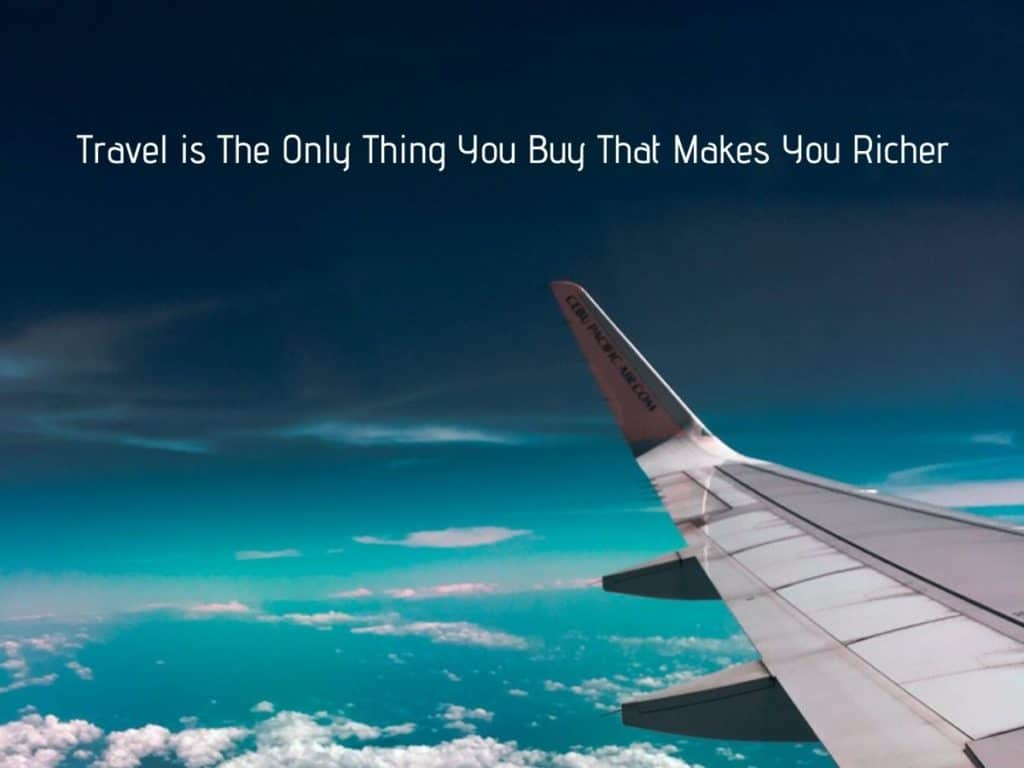

Pic Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.travelinglifestyle.net%2Ftop-inspiring-travel-quotes%2F&psig=AOvVaw0_2RGfTTtlO2ELHSexgAxL&ust=1608155985021000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCPCf643-0O0CFQAAAAAdAAAAABAD